In [10]:
import pickle as pk
import os

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from helper_utils.utils import *
from evaluation.metrics import *

In [11]:
# Load everything

data_directory = "processed_data"
data_filename_base = "X_top300_201801_201912_30_m_final"
data_filename_ext = ".npz"
data_filename = data_filename_base+data_filename_ext

model_store_directory = "stored_models"
run_info_store_directory = "stored_models"

PLOTS_DIRECTORY = "plots"
DATASET_NAME = "bike-share"
MODEL_NAMES = ["FNN"]

run_info = {}

for model_name in MODEL_NAMES:

    run_info_store_filename = "_".join([model_name, "run_info"]) + ".pk"
    run_info_store_filepath = os.path.join(run_info_store_directory, run_info_store_filename)
    run_info[model_name] = (pk.load(open(run_info_store_filepath, "rb")))
    
# history_dict = run_info["history"]
# preds = run_info["predictions"]

data = {}
with np.load(os.path.join(data_directory, data_filename)) as npz_loader:
    for key in npz_loader.files:
        print("{}: {}".format(key, npz_loader[key].shape))
        data[key] = npz_loader[key]

X_train = data["X_train"]
y_train = data["y_train"]
X_val = data["X_val"]
y_val = data["y_val"]
X_test = data["X_test"]
y_test = data["y_test"]

# Input and output dims
input_shape = tuple(list(X_train.shape)[1:])
output_shape = tuple(list(X_train.shape)[1:])
input_dims = np.product(input_shape)
output_dims = np.product(output_shape)

num_nodes, num_steps, input_features = input_shape
_, _, output_features = output_shape


X_train: (17725, 300, 10, 4)
y_train: (17725, 300, 10, 2)
X_val: (3545, 300, 10, 4)
y_val: (3545, 300, 10, 2)
X_test: (7090, 300, 10, 4)
y_test: (7090, 300, 10, 2)


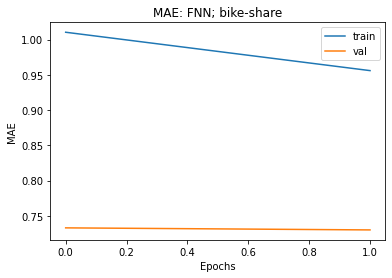

In [14]:
for MODEL_NAME in MODEL_NAMES:
    plt.figure()
    plt.title("MAE: "+MODEL_NAME+'; '+DATASET_NAME)
    plt.xlabel("Epochs")
    plt.ylabel("MAE")
    plt.plot(run_info[MODEL_NAME]['history']['loss'],label='train')
    plt.plot(run_info[MODEL_NAME]['history']['val_loss'],label='val')
    plt.legend()
    plt.savefig(os.path.join(PLOTS_DIRECTORY,'loss_'+MODEL_NAME+'_'+DATASET_NAME+'.png'))

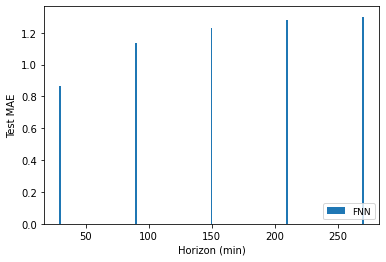

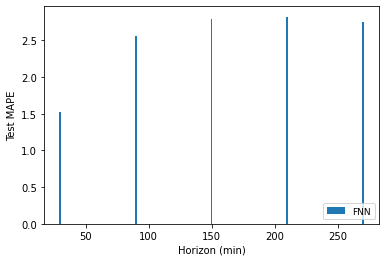

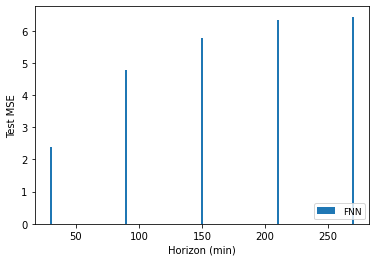

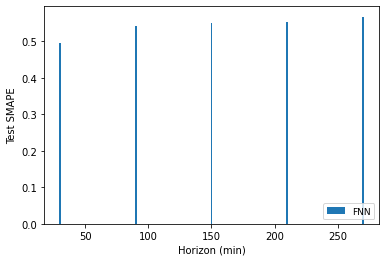

In [6]:
loss_funcs = {'MAE':mae_losses,
              'MAPE':mape_losses,
              'MSE':mse_losses,
              'SMAPE': smape_losses}

window_length = 10
window_size = 30
window_unit = 'min'
bar_width = 1.4
horizons = [0,2,4,6,8]
bar_locations = lambda i, MODEL_NAMES : (np.arange(1,1+window_length)*window_size+bar_width*(i-len(MODEL_NAMES)//2))[horizons]

loss_axes = (0,1,3)
ylabel = 'total loss'

for loss in loss_funcs:

    plt.figure()
#     plt.title("Test "+loss+"; "+DATASET_NAME)
    
    for i,MODEL_NAME in enumerate(MODEL_NAMES):
        losses = loss_funcs[loss](run_info[MODEL_NAME]['predictions'],y_test,axes=loss_axes)
        plt.bar(bar_locations(i,MODEL_NAMES),losses[horizons],width=bar_width,label=MODEL_NAME)

    plt.xlabel(f"Horizon ({window_unit})")
    plt.ylabel('Test ' + loss)
    plt.legend(loc='lower right',prop={'size': 9})
    plt.savefig(os.path.join(PLOTS_DIRECTORY,loss+'_comparison_'+DATASET_NAME+'.png'))

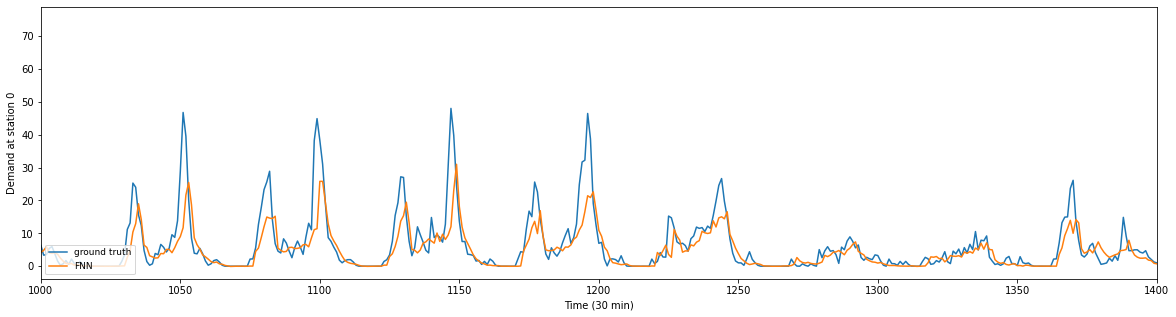

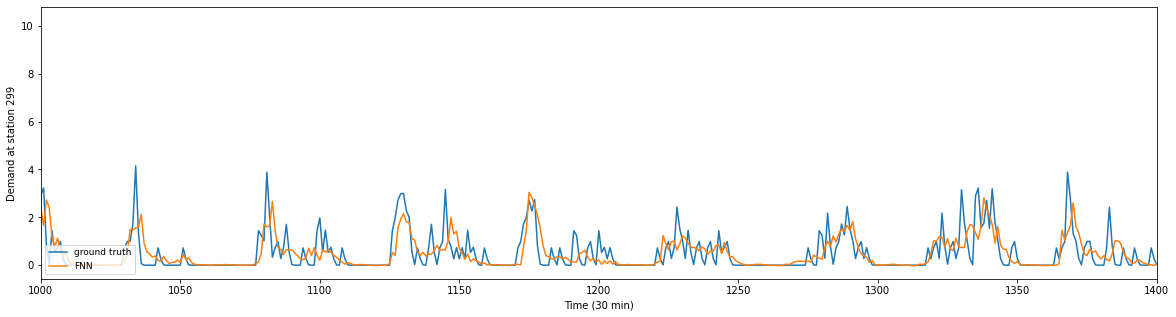

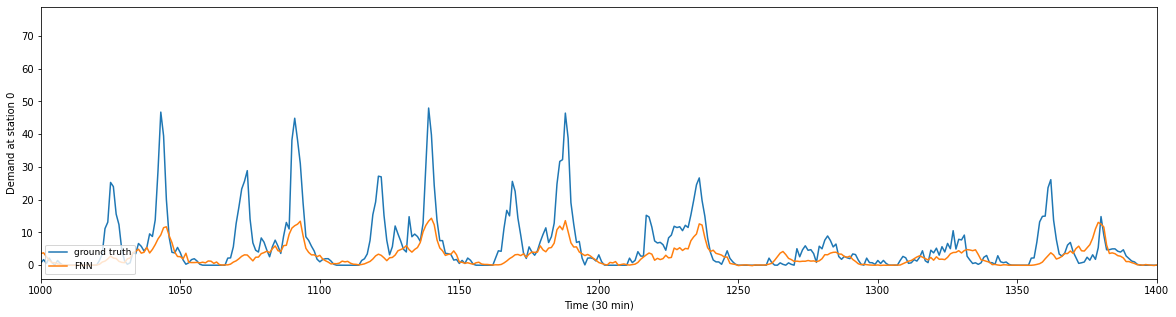

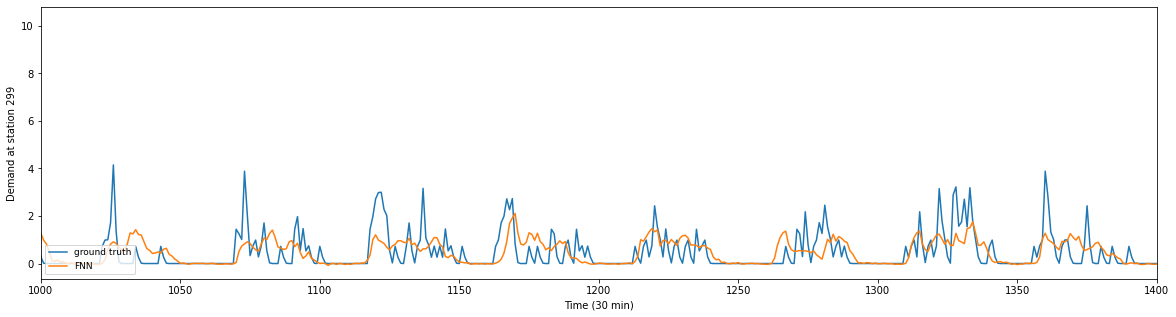

In [5]:
stations = [0,299]
horizons = [1,9]
feature = 0
feature_names = {0: 'Demand', 1: 'Supply'}
xlim = (1000, 1400)

save = False

for horizon in horizons:
    
    horizon_ground_truth = seq_from_windows(y_test, horizon=horizon)
    
    for station in stations:
        
        plt.figure(figsize=(20,5))
        plt.xlim(xlim)
        plt.xlabel("Time (30 min)")
        plt.ylabel(f"{feature_names[feature]} at station {station}")
        
        plt.plot(horizon_ground_truth[station,:,feature],label='ground truth')
        
        for MODEL_NAME in MODEL_NAMES:
            
            horizon_predictions = seq_from_windows(run_info[MODEL_NAME]['predictions'], horizon=horizon)
            plt.plot(horizon_predictions[station,:,feature],label=MODEL_NAME)
        
        plt.legend(loc='lower left',prop={'size': 9})
        
        if save:
            plt.savefig(os.path.join(PLOTS_DIRECTORY,'station'+str(station)+'_','horizon_'+str(horizon+1)+'_'+DATASET_NAME+'.png'))